In [1]:
# import packages
import datetime
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import umap
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.regularizers import l2
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')


2024-12-15 13:09:41.668941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734264581.690744   56352 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734264581.696629   56352 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 13:09:41.720271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('faults.csv')
df.columns = map(str.lower, df.columns)
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas']
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults']
enc_dict = {'pastry' : 0,
            'z_scratch' : 1,
            'k_scatch' : 2,
            'stains' : 3,
            'dirtiness' : 4,
            'bumps' : 5,
            'other_faults' : 6}
df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
sm = SMOTE()
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)
df_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)
df_nonbin = df_res.drop(['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly'], axis = 1)#.drop(target_cols, axis = 1)
sc = StandardScaler()
nonbin_norm = sc.fit_transform(df_nonbin)
df_nonbin_norm = pd.DataFrame(nonbin_norm, columns = df_nonbin.columns)
df_norm = df_nonbin_norm.copy()
df_norm[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']] = df_res[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']]
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum'], axis = 1, inplace = True)
df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)
df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)
df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)
df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)
df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

In [3]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
y = tf.keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [4]:
# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 10

# Define the Functional API model
inputs = Input(shape=(input_dim,))
x = Dense(128, activation='relu', kernel_constraint=UnitNorm(axis=0), kernel_regularizer=l2(0.01))(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_constraint=UnitNorm(axis=0), kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
bottleneck = Dense(encoding_dim, activation='relu', name='bottleneck')(x)
x = Dropout(0.2)(bottleneck)
x = Dense(64, activation='relu', kernel_constraint=UnitNorm(axis=1), kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_constraint=UnitNorm(axis=1), kernel_regularizer=l2(0.01))(x)
outputs = Dense(input_dim, activation='relu')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

# Extract the encoder
encoder = Model(inputs, bottleneck)

model.summary()


I0000 00:00:1734264585.688055   56352 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3490 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,251 (98.64 KB)

 Trainable params: 24,867 (97.14 KB)

 Non-trainable params: 384 (1.50 KB)

In [5]:
# Train the autoencoder
model.fit(X_train, X_train, epochs = 100, batch_size = 32, shuffle = True, validation_data = (X_test, X_test), verbose = 0)

I0000 00:00:1734264589.789561   56516 service.cc:148] XLA service 0x7f49580111b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734264589.789602   56516 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-12-15 13:09:49.885441: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734264590.322349   56516 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1734264594.730435   56516 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# Use encoder part of the autoencoder for feature selection
encoder = Model(inputs = model.input, outputs = model.get_layer('bottleneck').output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Encoded Features Shape (Train): (3768, 10)
Encoded Features Shape (Test): (943, 10)


In [7]:
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)

# Initialize the SVM classifier
svm_classifier = SVC(kernel = 'rbf', random_state = 42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)
grid.fit(encoded_features_train, y_train)
y_pred = grid.predict(encoded_features_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [8]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [9]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8494167550371156


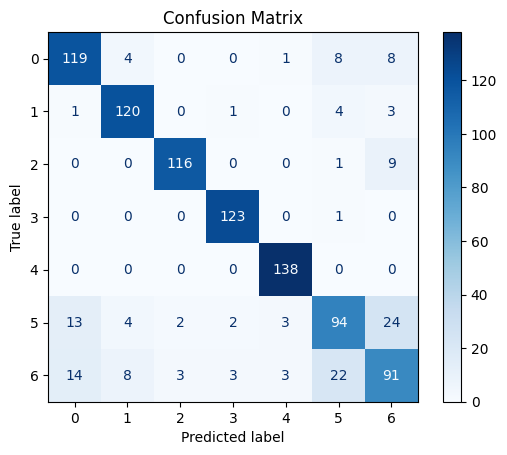

In [10]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = grid.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

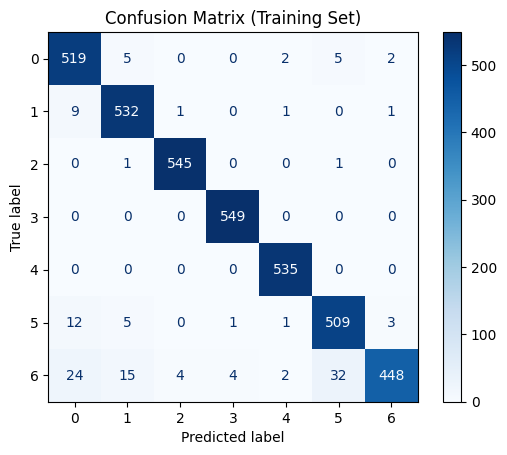

In [11]:
# Predict on the training set
y_train_pred = grid.predict(encoded_features_train)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=grid.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Training Set)")
plt.show()

In [12]:
print("Accuracy:", accuracy_score(y_train, y_train_pred))

Accuracy: 0.9652335456475584
